Exercise solution of the tutorial; https://www.tensorflow.org/tutorials/keras/text_classification

Import necessary libraries.

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import random
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
print(tf.__version__)

2.3.0


### Download and explore the Stack Overflow Programming Questions DB

 We will be predicting the tag a programming question might have on StackOverflow.com

In [15]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k.tar", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='stack_overflow_ds')

dataset_dir = os.path.dirname(dataset)

In [17]:
os.listdir(dataset_dir)

['README.md', 'stack_overflow_16k.tar.tar.gz', 'test', 'train']

In [18]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

Extract an example record from the database

In [19]:
sample_file = os.path.join(train_dir, 'java/0.txt')
with open(sample_file) as f:
  print(f.read())

"how to download .msi file in blank i want to download .msi file using blank.  i have tried to download file using following code..printwriter out = null;.fileinputstream filetodownload = null;.bufferedreader bufferedreader = null;.try {.        out = response.getwriter();.        filetodownload = new fileinputstream(download_directory + file_name);.        bufferedreader = new bufferedreader(new inputstreamreader(filetodownload));..        //response.setcontenttype(""application/text"");.        //response.setcontenttype(""application/x-msi"");.        //response.setcontenttype(""application/msi"");.        //response.setcontenttype(""octet-stream"");.        response.setcontenttype(""application/octet-stream"");.        //response.setcontenttype(""application/x-7z-compressed"");.        //response.setcontenttype(""application/zip"");.        response.setheader(""content-disposition"",""attachment; filename="" +file_name );.        response.setcontentlength(filetodownload.available())

Assign training set.

In [23]:
batch_size = 32
seed = 30

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_ds/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


Create validation set from training set.

In [24]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_ds/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


Assign test set.

In [25]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_ds/test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [26]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Standardize, tokenize and vectorize data, creating integer indeces for each token

In [29]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [30]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [31]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Caching for increased performance. (Prevents bottleneck due to slow storage devices)

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Define the model. We will feed the Dense layer with the parameter 4 since we will have four output labels; 'csharp', 'java', 'javascript' and 'python' respectively.

In [40]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


### Loss function and optimizer

SparseCategoricalCrossentropy Loss should be selected when integer labels are used.


In [43]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalCrossentropy())

### Training the model


In [44]:
epochs = 25

mycallbacks = [
    callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=mycallbacks,
)

Epoch 1/25
200/200 [==============================] - 5s 25ms/step - loss: 2.2979 - sparse_categorical_crossentropy: 2.2979 - val_loss: 1.4572 - val_sparse_categorical_crossentropy: 1.4572
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 1.4599 - sparse_categorical_crossentropy: 1.4599 - val_loss: 1.3901 - val_sparse_categorical_crossentropy: 1.3901
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 1.4080 - sparse_categorical_crossentropy: 1.4080 - val_loss: 1.3815 - val_sparse_categorical_crossentropy: 1.3815
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 1.4040 - sparse_categorical_crossentropy: 1.4040 - val_loss: 1.3791 - val_sparse_categorical_crossentropy: 1.3791
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 1.4016 - sparse_categorical_crossentropy: 1.4016 - val_loss: 1.3787 - val_sparse_categorical_crossentropy: 1.3787
Epoch 6/25
200/200 [==============================] - 1s 3m

### Evaluate the model


Create integer indeces for each token

In [46]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_crossentropy', 'val_loss', 'val_sparse_categorical_crossentropy'])

In [45]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 5s 19ms/step - loss: 1.3818 - sparse_categorical_crossentropy: 1.3818
Loss:  1.3818273544311523
Accuracy:  1.3818273544311523


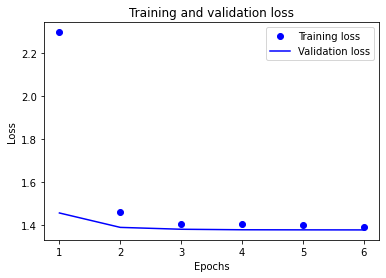

In [51]:
acc = history_dict['sparse_categorical_crossentropy']
val_acc = history_dict['val_sparse_categorical_crossentropy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
 
epochs = range(1, len(acc) + 1)
 
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()





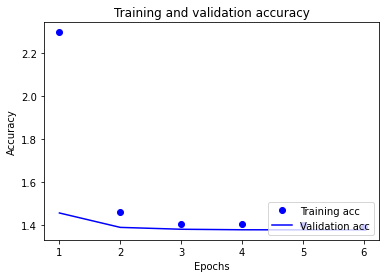

In [52]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

Create integer indeces for each token

In [53]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 5s 21ms/step - loss: 1.3860 - accuracy: 0.2853
0.2852500081062317


In [58]:
examples = [
  "csharp nodejs was great!",
]

export_model.predict(examples)

array([[0.52078927, 0.51363415, 0.5215138 , 0.5185645 ]], dtype=float32)